<a href="https://colab.research.google.com/github/tiffanytang34/Age_Detection_Using_Facial_Image_with_CNN/blob/main/1.EDA_age_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports

from zipfile import ZipFile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

Exploratory Data Analysis

### *facial-age* dataset (9,778 images)

In [3]:
# Unzipping the dataset file facial-age.zip

#!unzip facial-age.zip
facial_age_zip_path = "/content/drive/My Drive/Age_Detection/facial-age.zip"

with ZipFile(facial_age_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping facial-age.zip')

Done unzipping facial-age.zip


***facial-age* dataset** contains **9,778 RGB images of faces** in **PNG** format of size **200x200 pixels** each. The images are separated into folders where the **folder names correspond to the age labels of images inside those folders**.

In [4]:
# Accessing all folder names to get list of labels.

facial_age_path = "facial-age"
facial_age_folders = os.listdir(facial_age_path)

In [5]:
# Sorting the folder names (age labels) in ascending order.

facial_age_folders = np.sort(facial_age_folders)
facial_age_folders

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '095', '096', '099', '100', '101', '110'],
      dtype='<U3')

 Access the images in the folder and store the info inside a dictionary which has age labels as keys and number of images of certain ages as values. 

In [6]:
facial_age_images = {}

for age in facial_age_folders:
    temp_path = os.path.join(facial_age_path, age)
    n_images = len(os.listdir(temp_path))
    facial_age_images[int(age)] = n_images

### *UTKFace* dataset (23,708 images)

In [7]:
# Unzipping the dataset file UTKFace.zip

utkface_zip_path = "/content/drive/My Drive/Age_Detection/UTKFace.zip"

with ZipFile(utkface_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping UTKFace.zip')

Done unzipping UTKFace.zip


***UTKFace* dataset** contains **23,708 RGB images of faces** in **JPG** format of size **200x200 pixels** each. The **labels of images are embedded in the file names, formatted like *\[age]\_\[gender]\_\[race]\_\[date&time].jpg***.

In [8]:
# Accessing all image file names so as to be able to separate the age labels.

utkface_path = '/content/UTKFace'
utkface_image_names = os.listdir(utkface_path)

In [9]:
# Defining a function to generate the labels from the image file names according to the format given above.

def age_gender_race_split(image_name):
    image_labels = image_name.split('_')
    age = image_labels[0]
    gender = image_labels[1]
    race = image_labels[2]

    return (age, gender, race)

In [10]:
# Applying the above function on each image file name using a for loop and storing the labels in relevant arrays.

utkface_age_labels = np.array([])
utkface_gender_labels = np.array([])
utkface_race_labels = np.array([])

for image in utkface_image_names:
    age, gender, race = age_gender_race_split(image)
    utkface_age_labels = np.append(utkface_age_labels, age)
    utkface_gender_labels = np.append(utkface_gender_labels, gender)
    utkface_race_labels = np.append(utkface_race_labels, race)

In [11]:
# Grouping by the age labels and checking the no. of images per age label.

utkface_ages_counts = pd.Series(utkface_age_labels).value_counts()
utkface_ages_counts

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
91        2
101       2
111       1
103       1
Length: 104, dtype: int64

In [12]:
# Storing the grouped age labels series generated above in a dictionary with
# the age labels as keys and the no. of images per age label as values.

utkface_images = {}

for age, counts in utkface_ages_counts.items():
    utkface_images[int(age)] = counts

In [13]:
# Grouping by the gender labels and checking the no. of images per gender label.
# 0 = Male, 1 = Female
# This is just for extra info and will not be used in the model.

pd.Series(utkface_gender_labels).value_counts()

0    12391
1    11317
dtype: int64

In [14]:
# Grouping by the race labels and checking the no. of images per race label.
# 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others (like Hispanic, Latino, Middle Eastern)
# This is just for extra info and will not be used in the model.

pd.Series(utkface_race_labels).value_counts()

# 3 images don't have race labels in their file name, as seen below.

0                                 10078
1                                  4526
3                                  3975
2                                  3434
4                                  1692
20170109142408075.jpg.chip.jpg        1
20170109150557335.jpg.chip.jpg        1
20170116174525125.jpg.chip.jpg        1
dtype: int64

### Classes for Age Classification

In this part, I will **combine the different age labels into classes of age-ranges** so as to prepare the datasets for age classification modelling later. 
The classes of ages need to be established according to the number of images available per age label. In this way, the classes of ages will be balanced. This will ensure that the classification model learns to classify each age-range equally.

In [15]:
# Checking no. of unique age values in facial-age dataset.

facial_age_ages = list(facial_age_images.keys())
len(facial_age_ages)

99

In [16]:
# Checking no. of unique age values in UTKFace dataset.

utkface_ages = list(utkface_images.keys())
len(utkface_ages)

104

In [17]:
# Combining the lists of age values from the two datasets and
# converting the combined list to a set to keep only the unique age values.

facial_age_ages.extend(utkface_ages)
unique_ages = set(facial_age_ages)

In [18]:
# Checking no. of unique age values in both datasets combined.

len(unique_ages)

104

In [19]:
# Creating a dictionary of age labels as keys and no. of images per age label in both datasets combined as values,
# using the two dictionaries defined above.

combined_images = {}

for age in unique_ages:
    fc_image = 0
    utk_image = 0

    # Using try-except loop to avoid KeyError in case a particular age value does not exist in the dictionary.
    try:
        fc_image = facial_age_images[age]
    except:
        pass
    
    try:
        utk_image = utkface_images[age]
    except:
        pass
    
    # Summing up the no. of images for the age label.
    combined_images[age] = fc_image + utk_image

In [20]:
# Checking total no. of images in both datasets combined to ensure correctness of above code.

sum(combined_images.values())

33486

In [21]:
# Checking total no. of images by summing up no. of images in facial-age and UTKFace datasets.

sum(facial_age_images.values()) + sum(utkface_images.values())

33486

In [22]:
# Creating a dataframe to store the no. of images per age label in facial-age dataset, UTKFace dataset and the combined dataset.

images_df = pd.DataFrame(combined_images.values(), index=combined_images.keys(), columns=['combined_images'])
images_df['facial_age_images'] = pd.Series(facial_age_images)
images_df['utkface_images'] = pd.Series(utkface_images)

images_df

,combined_images,facial_age_images,utkface_images
1,2235,1112.0,1123
2,957,475.0,482
3,573,284.0,289
4,533,260.0,273
5,376,180.0,196
...,...,...,...
105,5,NaN,5
110,7,2.0,5
111,1,NaN,1
115,3,NaN,3


In [23]:
# Imputing the null values in above dataframe with 0s.

images_df.fillna(0, inplace=True)
images_df = images_df.astype(int)

images_df

,combined_images,facial_age_images,utkface_images
1,2235,1112,1123
2,957,475,482
3,573,284,289
4,533,260,273
5,376,180,196
...,...,...,...
105,5,0,5
110,7,2,5
111,1,0,1
115,3,0,3


In [24]:
# Exporting above created dataframe as a CSV file.

images_df.to_csv("/content/drive/My Drive/Age_Detection/image_summary.csv", index=True, index_label='age')

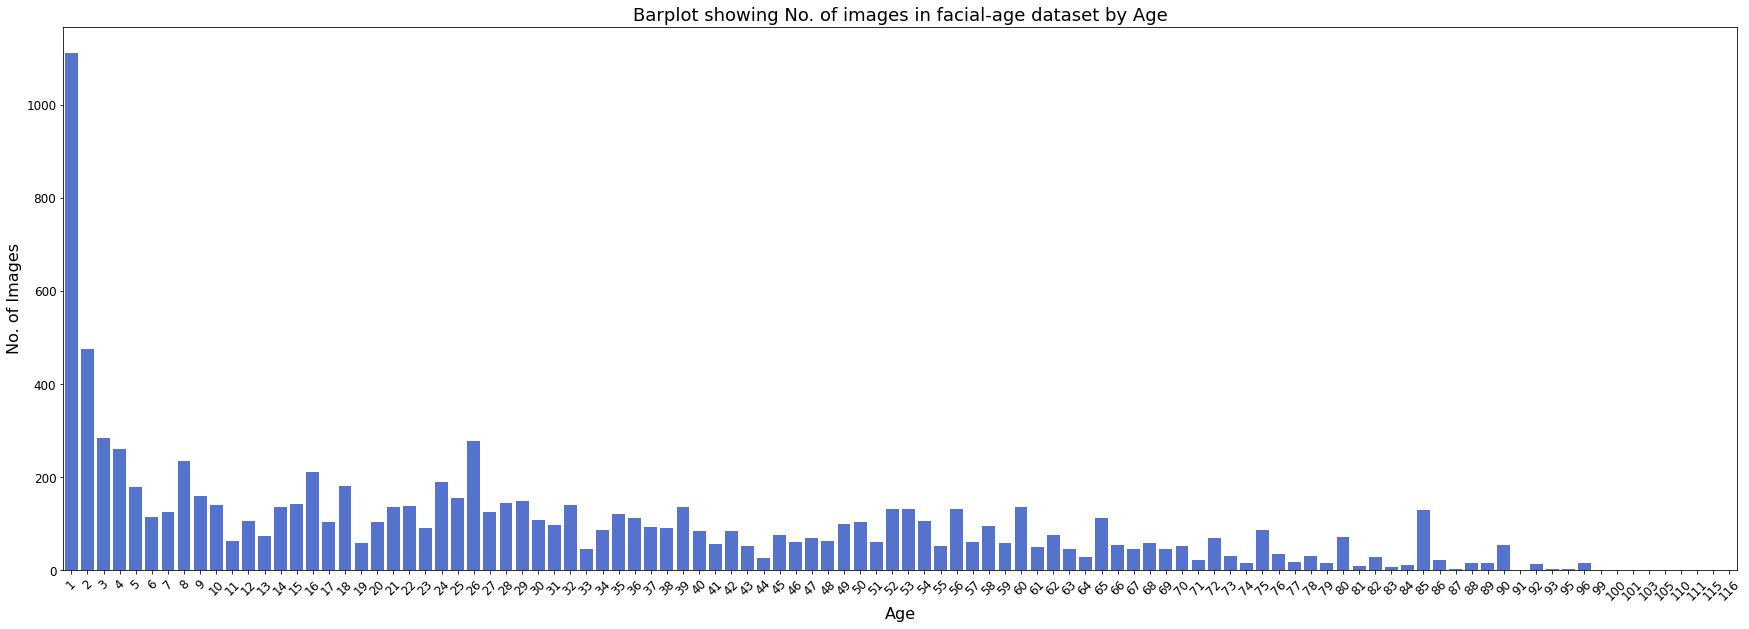

In [25]:
# Plotting the no. of images by ages in a barplot.

plt.figure(figsize=(30, 10))

ax = sns.barplot(x=images_df.index, y=images_df['facial_age_images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age", fontsize=16)
plt.ylabel("No. of Images", fontsize=16)

plt.title("Barplot showing No. of images in facial-age dataset by Age", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_facial_age_images.png', bbox_inches='tight');

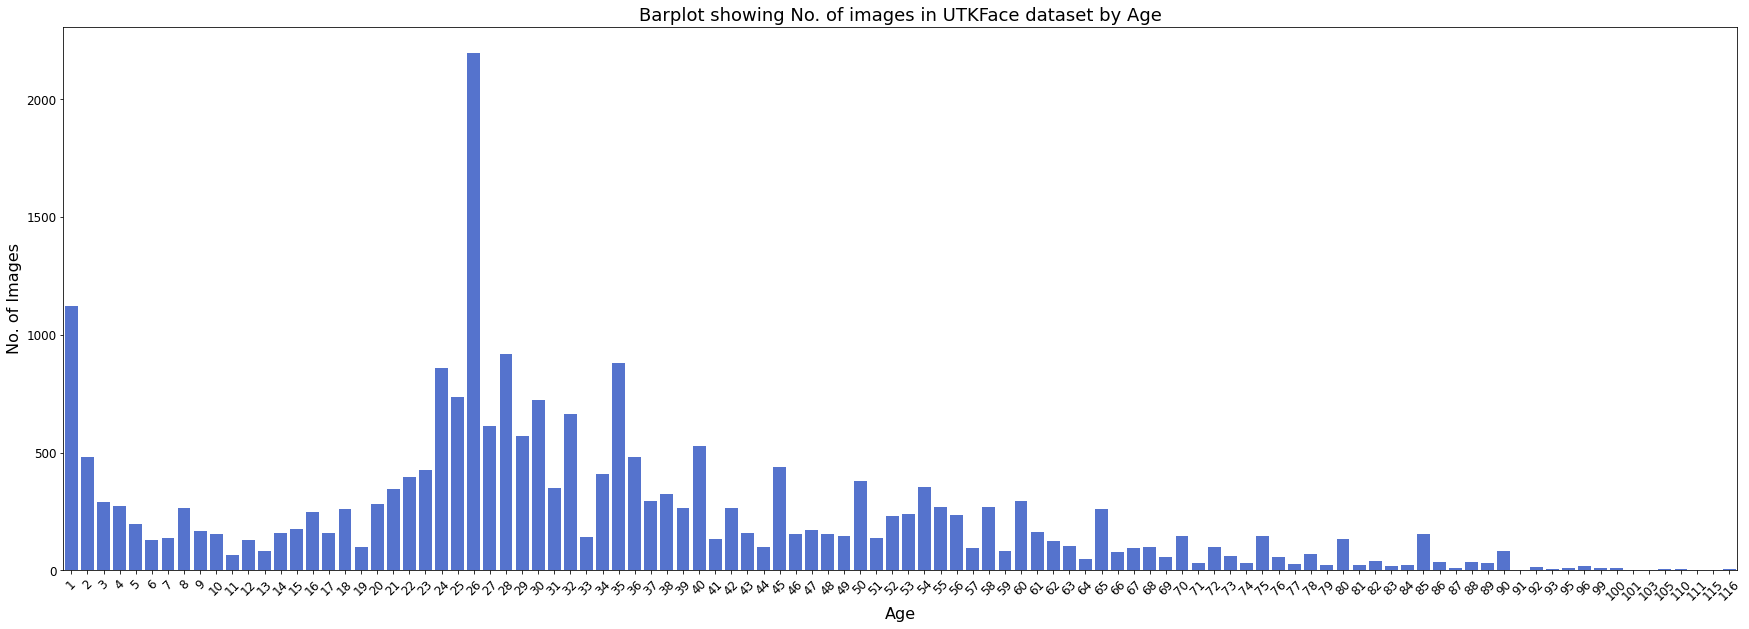

In [26]:
# Plotting the no. of images by ages in a barplot.

plt.figure(figsize=(30, 10))

ax = sns.barplot(x=images_df.index, y=images_df['utkface_images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age", fontsize=16)
plt.ylabel("No. of Images", fontsize=16)

plt.title("Barplot showing No. of images in UTKFace dataset by Age", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_utkface_images.png', bbox_inches='tight');

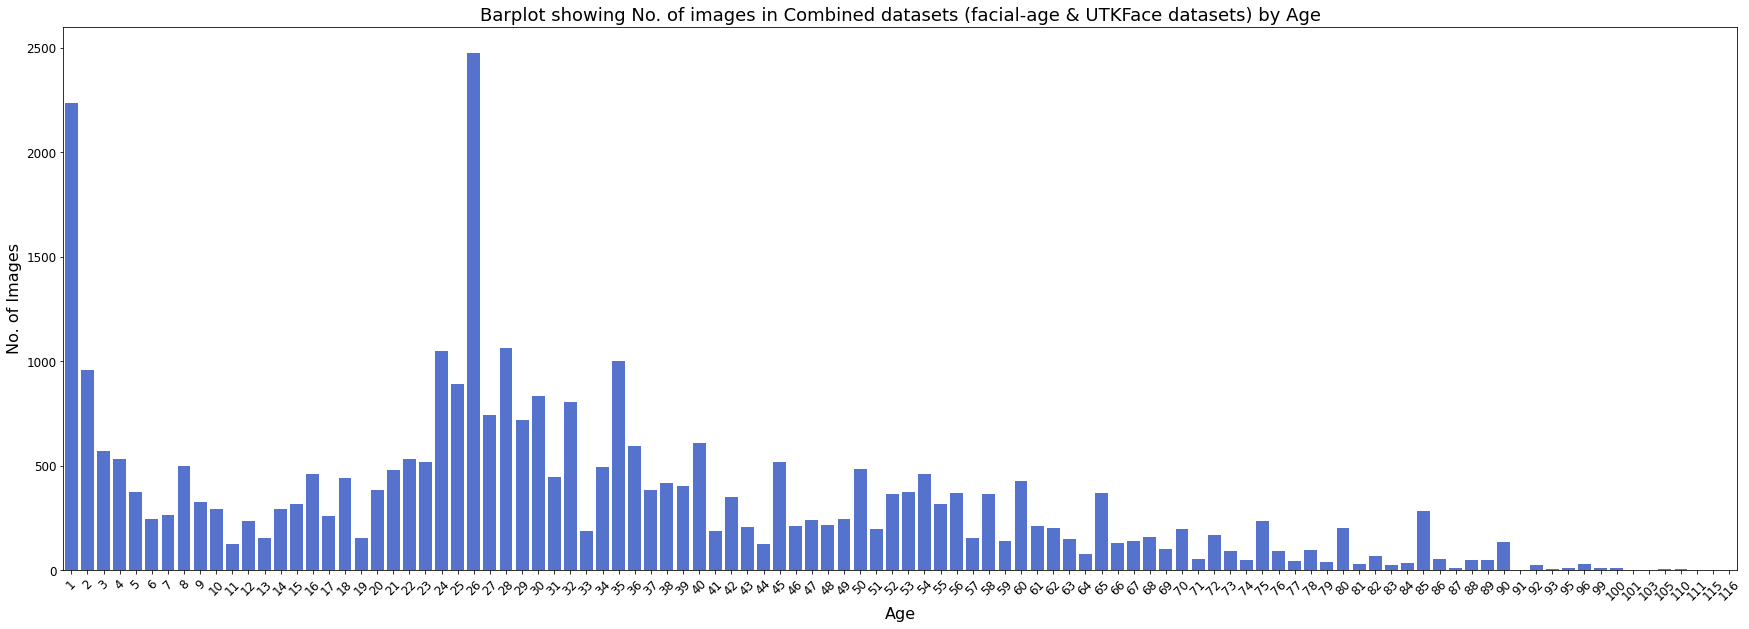

In [27]:
# Plotting the no. of images by ages in a barplot.

plt.figure(figsize=(30, 10))

ax = sns.barplot(x=images_df.index, y=images_df['combined_images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelrotation=45)

plt.xlabel("Age", fontsize=16)
plt.ylabel("No. of Images", fontsize=16)

plt.title("Barplot showing No. of images in Combined datasets (facial-age & UTKFace datasets) by Age", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_combined_faces_images.png', bbox_inches='tight');

I will now **combine the different age labels into classes of age-ranges** so as to prepare the datasets for age classification modelling. The different possible combinations of age ranges will be generated using a function defined below.

In [1]:
# Defining a function to split the images in each dataset into n classes (user input).
# Function INPUT: Dataset series of no. of images per age index, and n_classes. 
# Function OUTPUT: Dataset broken up into n_classes with age-ranges, no. of images and proportion balance per class.

def split_classes(ser, n_classes):

    # Calculating the target number of images per class depending on the total no. of images in the dataset.
    n_images = int(sum(ser) / n_classes)

    print(f"Total no. of images in dataset\t= {sum(ser)}")
    print(f"No. of classes desired\t\t= {n_classes}")
    print(f"So, target no. of images/class\t>= {sum(ser)}/{n_classes} = ~{n_images}")
    print()

    # Initiating a dataframe to show the breakdown of age-ranges as output.
    classes_df = pd.DataFrame(columns=['Age-ranges (classes)', 'No. of images', 'Class balance (%)'])

    # Initiating an age index variable to be used to iterate through the ages in the given input series.
    age_index = 0

    for i in range(n_classes):

        # Storing the starting age of the class in a variable age_start.
        # Storing the current age being iterated in a variable age_current.
        # Keeping track of age_index variable so as not to let it go out of index.
        if age_index<=103:
            age_start = ser.index[age_index]
            age_current = ser.index[age_index]
        else:
            break

        # Initiating a new variable to keep track of no. of images added to current class.
        class_images = 0
        
        # Iterating through the ages in the given input series and adding up the no. of images
        # until it exceeds the target number of images per class, using the age_index and age_current variables.
        while class_images < n_images:
            class_images += ser[age_current]
            age_index += 1

            # Keeping track of age_index variable so as not to let it go out of index.
            if age_index<=103:
                age_current = ser.index[age_index]
            else:
                break

        # Storing the ending age of the class in a variable age_end.
        # Keeping track of age_index variable so as not to let it go out of index.
        if age_index<=104:
            age_end = ser.index[age_index-1]
        else:
            break
        
        # Adding the above calculated variables into the dataframe for easier printing and analysis.
        classes_df.loc[i, 'Age-ranges (classes)'] = str(age_start)+" - "+str(age_end)
        classes_df.loc[i, 'No. of images'] = class_images
        classes_df.loc[i, 'Class balance (%)'] = round((class_images / sum(ser)) * 100, 2)
    
    # Calculating some basic statistics about no. of images and the class balance.
    mean_images = int(round(np.mean(classes_df.loc[:, 'No. of images'])))
    mean_balance = round(np.mean(classes_df.loc[:, 'Class balance (%)']), 2)
    std_balance = round(np.std(classes_df.loc[:, 'Class balance (%)']), 2)
    
    print(f"Mean no. of images/class\t= ~{mean_images}")
    print(f"Mean class balance\t\t= {mean_balance}%")
    print(f"Std. of class balance\t\t= {std_balance}%")
    print()

    # Returning the dataframe with all the classes info.
    return classes_df

In [28]:
# Applying the above function on facial-age dataset to split it into 11 classes.

facial_age_classes = split_classes(images_df['facial_age_images'], 11)
facial_age_classes

Total no. of images in dataset	= 9778
No. of classes desired		= 11
So, target no. of images/class	>= 9778/11 = ~888

Mean no. of images/class	= ~978
Mean class balance		= 10.0%
Std. of class balance		= 1.13%



,Age-ranges (classes),No. of images,Class balance (%)
0,1 - 1,1112,11.37
1,2 - 4,1019,10.42
2,5 - 10,955,9.77
3,11 - 18,1020,10.43
4,19 - 26,1154,11.8
5,27 - 34,901,9.21
6,35 - 45,935,9.56
7,46 - 56,1017,10.4
8,57 - 70,924,9.45
9,71 - 116,741,7.58


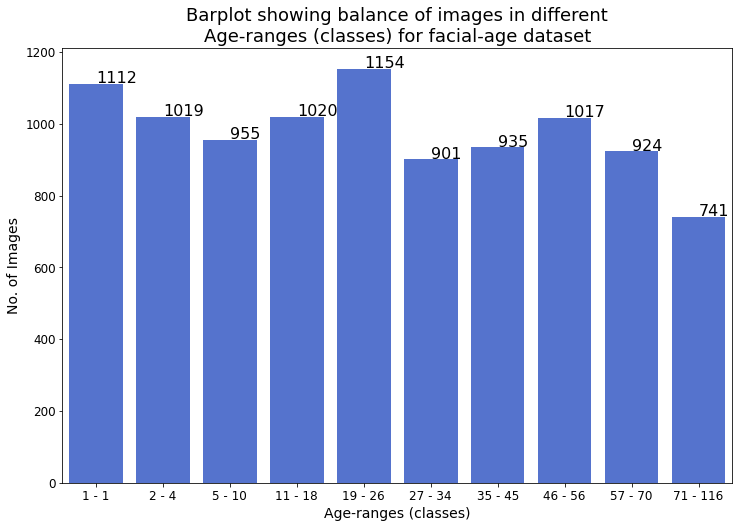

In [35]:
# Plotting the balance of images in different age-ranges in a barplot.

plt.figure(figsize=(12, 8))

ax = sns.barplot(x=facial_age_classes['Age-ranges (classes)'], y=facial_age_classes['No. of images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)

for i in range(10):
  plt.text(x=i , y =facial_age_classes['No. of images'].iloc[i]+2 , s=f"{facial_age_classes['No. of images'].iloc[i]}" , fontdict=dict(fontsize=16))
plt.xlabel("Age-ranges (classes)", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)

plt.title("Barplot showing balance of images in different\nAge-ranges (classes) for facial-age dataset", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_facial_age_images_in_classes.png', bbox_inches='tight');

In [36]:
# Applying the above function on UTKFace dataset to split it into 11 classes.

utkface_classes = split_classes(images_df['utkface_images'], 11)
utkface_classes

Total no. of images in dataset	= 23708
No. of classes desired		= 11
So, target no. of images/class	>= 23708/11 = ~2155

Mean no. of images/class	= ~2371
Mean class balance		= 10.0%
Std. of class balance		= 1.36%



,Age-ranges (classes),No. of images,Class balance (%)
0,1 - 4,2167,9.14
1,5 - 18,2328,9.82
2,19 - 24,2408,10.16
3,25 - 26,2931,12.36
4,27 - 30,2827,11.92
5,31 - 35,2446,10.32
6,36 - 42,2291,9.66
7,43 - 53,2313,9.76
8,54 - 65,2298,9.69
9,66 - 116,1699,7.17


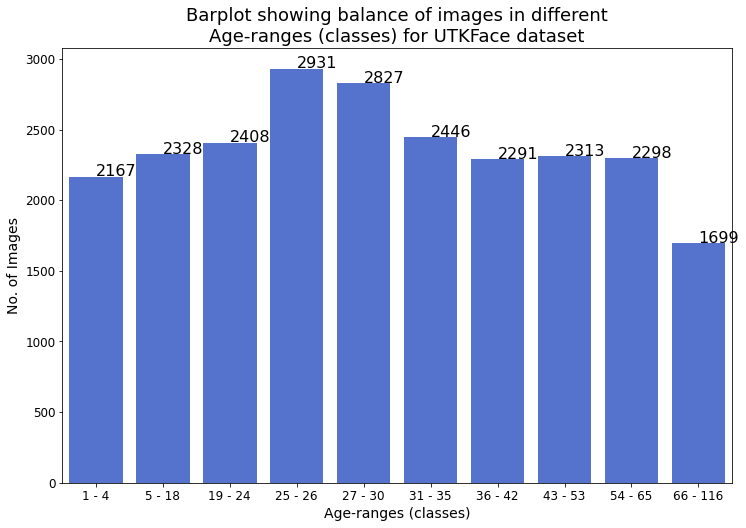

In [38]:
# Plotting the balance of images in different age-ranges in a barplot.

plt.figure(figsize=(12, 8))

ax = sns.barplot(x=utkface_classes['Age-ranges (classes)'], y=utkface_classes['No. of images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)

for i in range(10):
  plt.text(x=i , y =utkface_classes['No. of images'].iloc[i]+2 , s=f"{utkface_classes['No. of images'].iloc[i]}" , fontdict=dict(fontsize=16))
plt.xlabel("Age-ranges (classes)", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)

plt.title("Barplot showing balance of images in different\nAge-ranges (classes) for UTKFace dataset", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_utkface_images_in_classes.png', bbox_inches='tight');

In [39]:
# Applying the above function on the combined facial-age and UTKFace datasets to split them into 12 classes.

combined_classes = split_classes(images_df['combined_images'], 12)
combined_classes

Total no. of images in dataset	= 33486
No. of classes desired		= 12
So, target no. of images/class	>= 33486/12 = ~2790

Mean no. of images/class	= ~3044
Mean class balance		= 9.09%
Std. of class balance		= 0.68%



,Age-ranges (classes),No. of images,Class balance (%)
0,1 - 2,3192,9.53
1,3 - 9,2816,8.41
2,10 - 20,3136,9.37
3,21 - 25,3474,10.37
4,26 - 27,3217,9.61
5,28 - 31,3063,9.15
6,32 - 36,3086,9.22
7,37 - 45,3207,9.58
8,46 - 54,2802,8.37
9,55 - 65,2796,8.35


In [46]:
# Exporting above created dataframe as a CSV file.

combined_classes.to_csv("/content/drive/My Drive/Age_Detection/combined_faces_classes_summary.csv", index=True, index_label='Class label')

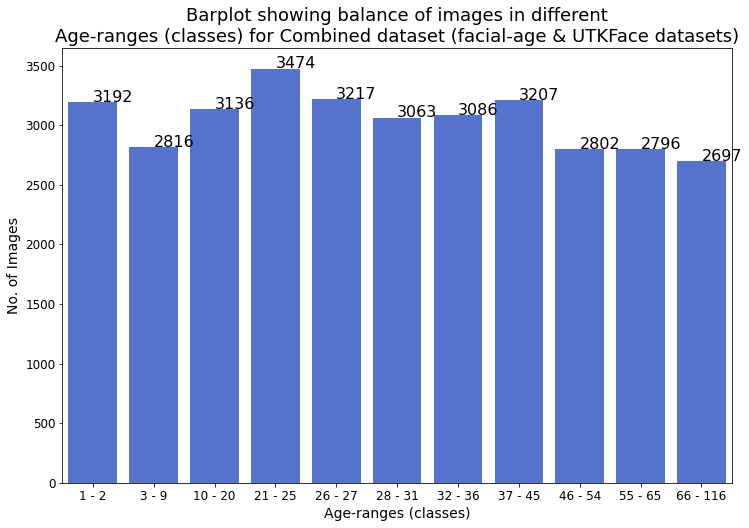

In [42]:
# Plotting the balance of images in different age-ranges in a barplot.

plt.figure(figsize=(12, 8))

ax = sns.barplot(x=combined_classes['Age-ranges (classes)'], y=combined_classes['No. of images'], color='royalblue')

ax.tick_params(axis='both', labelsize=12)

for i in range(11):
  plt.text(x=i , y =combined_classes['No. of images'].iloc[i]+2 , s=f"{combined_classes['No. of images'].iloc[i]}" , fontdict=dict(fontsize=16))
plt.xlabel("Age-ranges (classes)", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)

plt.title("Barplot showing balance of images in different\nAge-ranges (classes) for Combined dataset (facial-age & UTKFace datasets)", fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Age_Detection/plot_images/barplot_combined_faces_images_in_classes.png', bbox_inches='tight');

### Dataset Preperation

In this section, I will **merge the *facial-age* and *UTKFace* datasets into one *combined_faces* dataset**.

The PNG images from the *facial-age* dataset will also be **converted to JPG** format before merging. 

In [43]:
os.mkdir("combined_faces")

progress_counter = 0
age_file_counter = [1] * 117

print("Merging images from facial-age dataset into combined_faces.\n")

for age in facial_age_folders:
    age_path = os.path.join(facial_age_path, age)

    img_files = os.listdir(age_path)

    for img in img_files:

        img_src = os.path.join(age_path, img)

        new_filename = str(int(age)) + "_" + str(age_file_counter[int(age)]) + ".jpg"
        age_file_counter[int(age)] += 1

        img_dest = os.path.join("/content/combined_faces", new_filename)

        # Converting the .PNG images to .JPG so as to maintain consistency with of filetype throughout the combined datasets.
        png_image = cv2.imread(img_src)
        cv2.imwrite(img_dest, png_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

        progress_counter += 1

        if progress_counter % 1000 == 0:
            print(f"Images copied to combined_faces folder: {progress_counter} of 33486")

print("\nMerging images from UTKFace dataset into combined_faces.\n")

for img in utkface_image_names:

    file_type = img.split(".")[-1]
    age = img.split("_")[0]

    img_src = os.path.join(utkface_path, img)

    new_filename = age + "_" + str(age_file_counter[int(age)]) + "." + file_type
    age_file_counter[int(age)] += 1

    img_dest = os.path.join("/content/combined_faces", new_filename)

    shutil.copy(img_src, img_dest);
    progress_counter += 1

    if progress_counter % 1000 == 0:
        print(f"Images copied to combined_faces folder: {progress_counter} of 33486")

print("\nDone merging images from both datasets into combined_faces.")

Merging images from facial-age dataset into combined_faces.

Images copied to combined_faces folder: 1000 of 33486
Images copied to combined_faces folder: 2000 of 33486
Images copied to combined_faces folder: 3000 of 33486
Images copied to combined_faces folder: 4000 of 33486
Images copied to combined_faces folder: 5000 of 33486
Images copied to combined_faces folder: 6000 of 33486
Images copied to combined_faces folder: 7000 of 33486
Images copied to combined_faces folder: 8000 of 33486
Images copied to combined_faces folder: 9000 of 33486

Merging images from UTKFace dataset into combined_faces.

Images copied to combined_faces folder: 10000 of 33486
Images copied to combined_faces folder: 11000 of 33486
Images copied to combined_faces folder: 12000 of 33486
Images copied to combined_faces folder: 13000 of 33486
Images copied to combined_faces folder: 14000 of 33486
Images copied to combined_faces folder: 15000 of 33486
Images copied to combined_faces folder: 16000 of 33486
Images co

In [44]:
# Defining a function to get all paths of files before zipping combined_faces folder.

def get_all_file_paths(path):

    file_paths = []

    # Crawling through each directory and subdirectories at the given path.
    for root, dirs, files in os.walk(path):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)

    # Returning all file paths.
    return file_paths

# Calling above defined function to get file paths of all images before zipping the folder.
file_paths = get_all_file_paths("/content/combined_faces")

In [45]:
# Zipping the combined_faces dataset folder.

combined_faces_zip_path = "/content/drive/My Drive/Age_Detection/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'w') as myzip:
    for file in file_paths:
        myzip.write(file)
    print('Done zipping combined_faces!')

Done zipping combined_faces!
